# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import s3fs
import pyarrow as pa
from dotenv import load_dotenv
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import sklearn.preprocessing
import scipy
import sys
from implicit.als import AlternatingLeastSquares
import scipy.sparse
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

/home/mle-user/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("./ym/tracks.parquet")
catalog_names = pd.read_parquet("./ym/catalog_names.parquet")
interactions = pd.read_parquet("./ym/interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
print(tracks.info())
print(catalog_names.info())
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), i

In [5]:
display(tracks.head())
display(catalog_names.head())
interactions.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [3]:
# Проверка на пустые множества

empty_mask = tracks['albums'].apply(lambda x: len(x) == 0) | \
             tracks['artists'].apply(lambda x: len(x) == 0) | \
             tracks['genres'].apply(lambda x: len(x) == 0)

empty_tracks = tracks[empty_mask]
display(empty_tracks)

,track_id,albums,artists,genres
490,2520,"[249, 163801, 163802, 324616, 17542430, 189498...",[2259],[]
3069,16776,"[1479, 5319, 6093, 8467, 10641, 90867, 163801,...",[978],[]
3077,16801,"[1479, 163801, 9287549, 9377183, 9424994, 1201...",[10520],[]
4192,23752,"[2001, 3722, 4973, 6104, 6558, 23866, 37052, 7...",[13373],[]
6645,38012,"[3147, 60099, 530836, 1115289, 2490724, 818446...",[16758],[]
...,...,...,...,...
999868,101201589,[12649219],[],"[62, 77]"
999876,101219571,[9444321],[],"[62, 83, 77]"
999901,101243616,[11700332],[],"[62, 93]"
999920,101292599,[9331881],[],"[62, 90, 77, 84]"


In [4]:
# Таких треков не много, их можно удалить

tracks = tracks[~empty_mask]

In [5]:
types = catalog_names['type'].unique()
types

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [9]:
print(len(catalog_names))
catalog_names.id.nunique()

# разные числа говорят о том, что id не уникальные и повторяются, это надо исправить

1812471


1776697

In [10]:
for n in types:
    print(n, catalog_names[catalog_names['type'] == n]['id'].nunique())

album 658724
artist 153581
genre 166
track 1000000


In [6]:
# Удалим дубликаты по 'type', 'name'
catalog_names = catalog_names.drop_duplicates(subset=['type', 'name'], keep='first')

In [12]:
catalog_names

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1812451,101392428,track,ДСВ 2022
1812459,101399193,track,Аккаунт удалён
1812460,101399197,track,tendril
1812467,101490148,track,Без капли мысли


In [7]:
#взаимодействие с пропавшими треками удалим
interactions = interactions[~interactions['track_id'].isin(catalog_names.id)]

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [25]:
# С данными были проблемы и они были почищены с небольшими потерями)

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

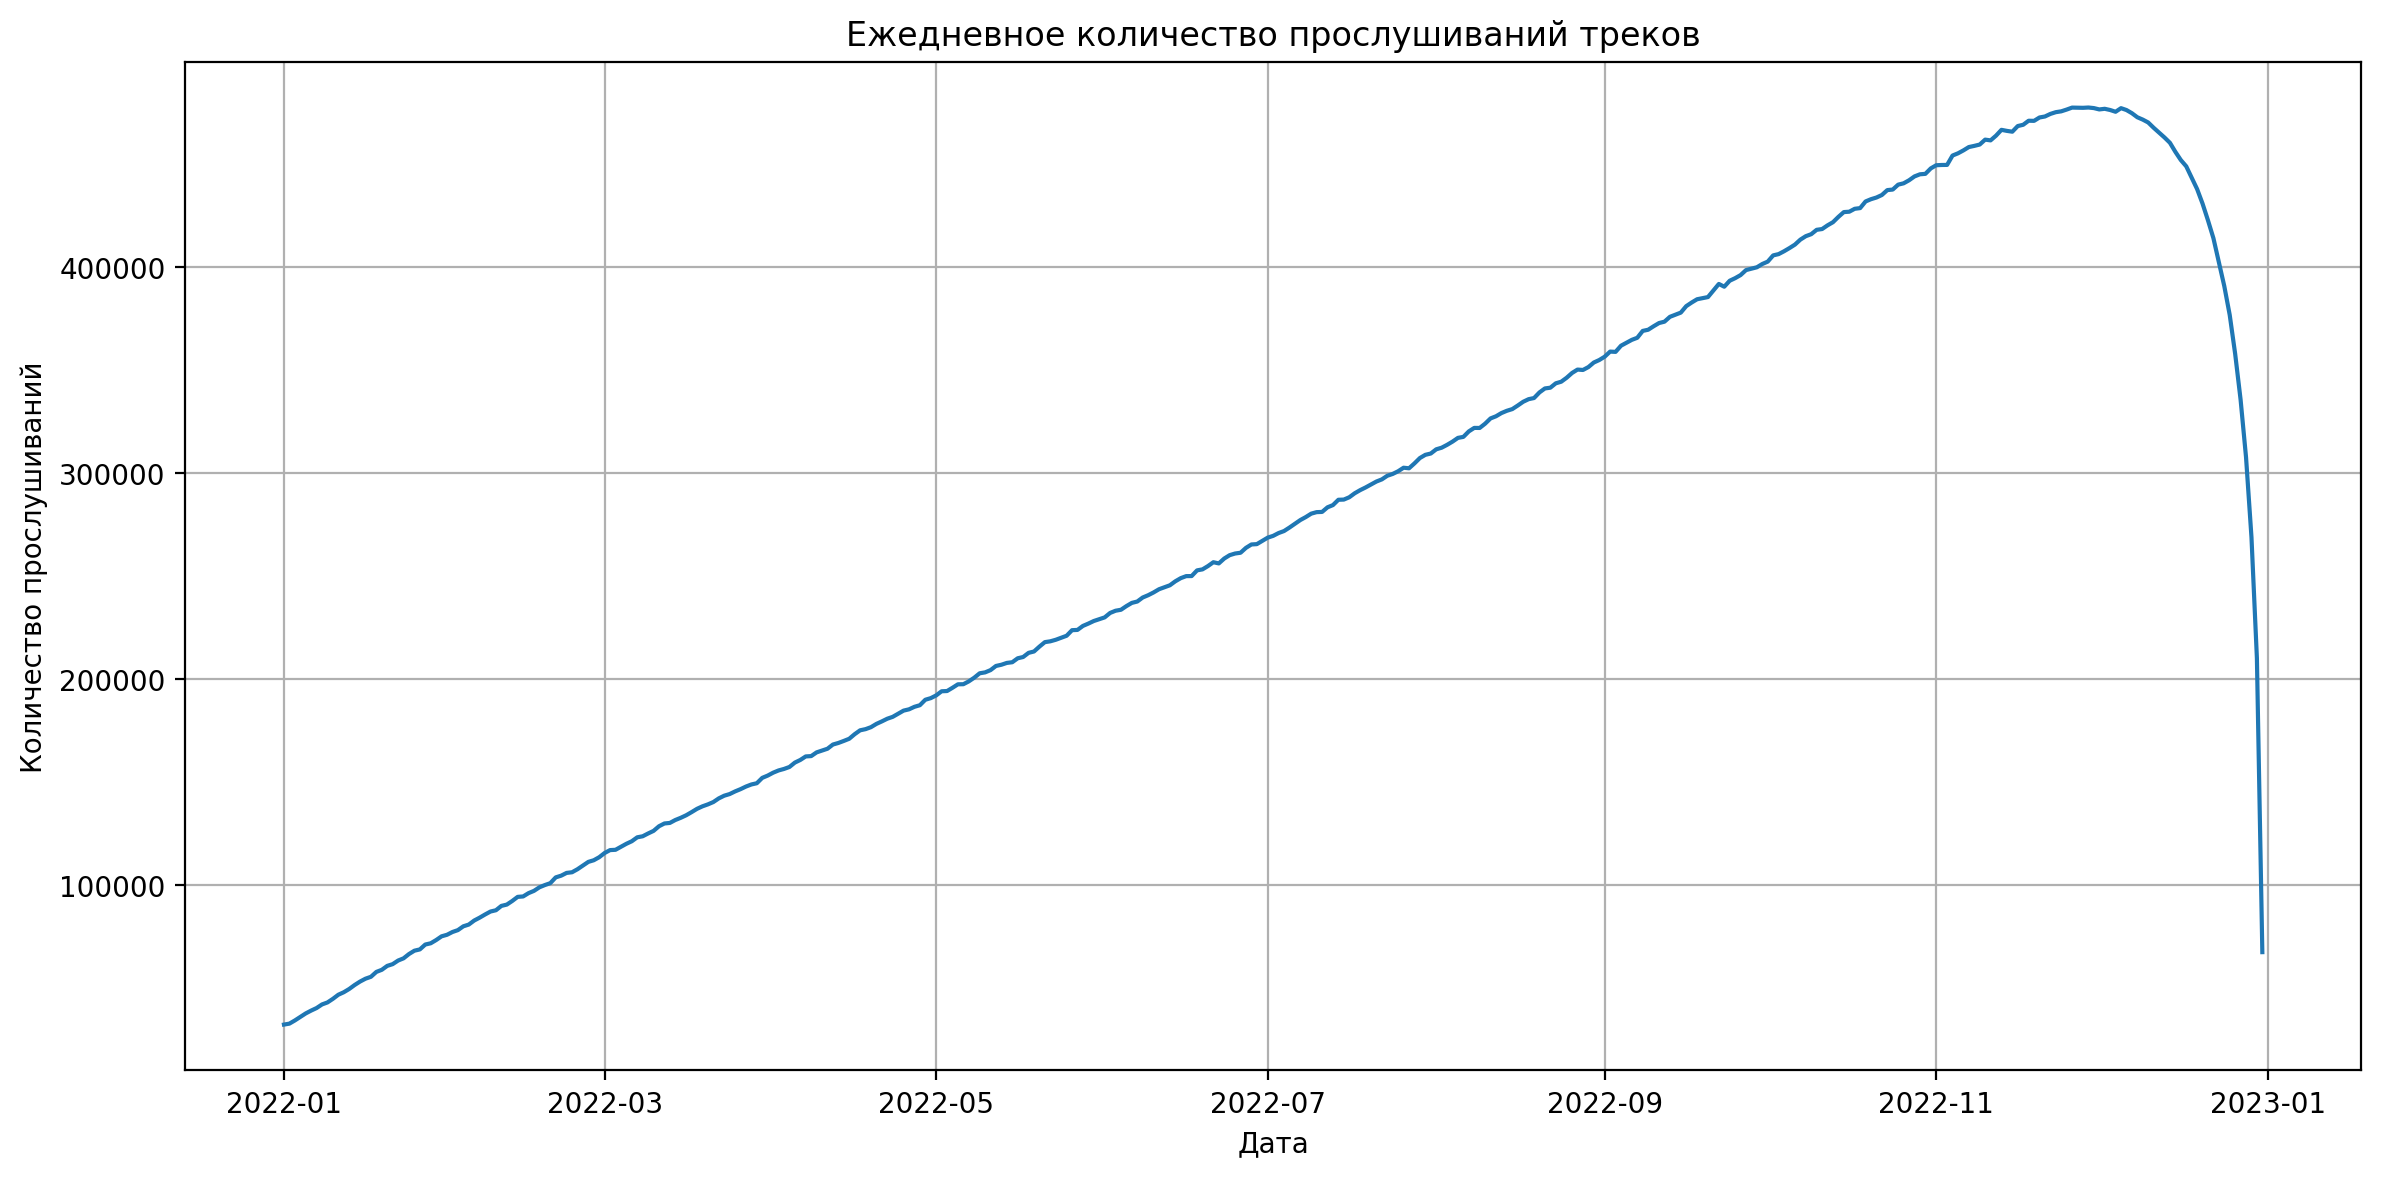

In [28]:
interactions['date'] = interactions['started_at'].dt.date

daily_counts = interactions.groupby('date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line')
plt.title('Ежедневное количество прослушиваний треков')
plt.xlabel('Дата')
plt.ylabel('Количество прослушиваний')
plt.grid(True)
plt.tight_layout()
plt.show()


Наиболее популярные треки

In [14]:
popular_tracks = interactions['track_id'].value_counts().reset_index()
popular_tracks.columns = ['track_id', 'play_count']
popular_tracks

,track_id,play_count
0,53404,111062
1,33311009,106921
2,178529,101924
3,35505245,99490
4,65851540,86670
...,...,...
463531,61927533,5
463532,84858434,5
463533,95853772,5
463534,28948882,5


Наиболее популярные жанры

In [15]:
interactions_with_genres = interactions.merge(tracks[['track_id', 'genres']], on='track_id', how='left')
interactions_with_genres = interactions_with_genres.dropna(subset=['genres'])
interactions_exploded = interactions_with_genres.explode('genres')

popular_genres = interactions_exploded['genres'].value_counts().reset_index()
popular_genres.columns = ['genre', 'play_count']
popular_genres

: 

In [ ]:
del interactions_exploded

Треки, которые никто не прослушал

In [15]:
played_track_ids = interactions['track_id'].dropna().unique()
unplayed_tracks = tracks[~tracks['track_id'].isin(played_track_ids)]

unplayed_tracks

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999980,101392428,[21375241],[675102],"[3, 75]"
999988,101399193,[21377596],[7992142],[11]
999989,101399197,[21377596],[7992142],[11]
999996,101490148,[21403052],[9078726],"[11, 20]"


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [8]:
tracks = tracks.explode("albums").explode("artists").explode("genres").reset_index(drop=True)
tracks = tracks.rename(columns={"albums":"album_id","artists":"artist_id","genres":"genre_id"})

In [9]:
tracks

,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11
...,...,...,...,...
6686875,101493057,21403883,11865715,75
6686876,101495927,21404975,4462686,3
6686877,101495927,21404975,4462686,75
6686878,101521819,21414638,5056591,3


In [10]:
catalog_filtered = catalog_names[catalog_names["type"].isin(["track", "album", "artist", "genre"])]

track_map  = catalog_filtered[catalog_filtered["type"] == "track"].set_index("id")["name"]
album_map  = catalog_filtered[catalog_filtered["type"] == "album"].set_index("id")["name"]
artist_map = catalog_filtered[catalog_filtered["type"] == "artist"].set_index("id")["name"]
genre_map  = catalog_filtered[catalog_filtered["type"] == "genre"].set_index("id")["name"]

tracks["track_name"]  = tracks["track_id"].map(track_map)
tracks["album_name"]  = tracks["album_id"].map(album_map)
tracks["artist_name"] = tracks["artist_id"].map(artist_map)
tracks["genre_name"]  = tracks["genre_id"].map(genre_map)
tracks

,track_id,album_id,artist_id,genre_id,track_name,album_name,artist_name,genre_name
0,26,3,16,11,Complimentary Me,Taller Children,Elizabeth & the Catapult,pop
1,26,3,16,21,Complimentary Me,Taller Children,Elizabeth & the Catapult,folk
2,26,2490753,16,11,Complimentary Me,NaN,Elizabeth & the Catapult,pop
3,26,2490753,16,21,Complimentary Me,NaN,Elizabeth & the Catapult,folk
4,38,3,16,11,Momma's Boy,Taller Children,Elizabeth & the Catapult,pop
...,...,...,...,...,...,...,...,...
6686875,101493057,21403883,11865715,75,SKITTLES,SKITTLES,WhyBaby?,rap
6686876,101495927,21404975,4462686,3,NaN,NaN,NaN,rusrap
6686877,101495927,21404975,4462686,75,NaN,NaN,NaN,rap
6686878,101521819,21414638,5056591,3,NaN,NaN,Джарахов,rusrap


In [ ]:
# Посмотрим отношение полностью треков с пропусками в данных ко всем трекам
len(tracks[tracks.isnull().any(axis=1)])/len(tracks)

0.5638939236235734

In [11]:
# оставим только треки со всеми данными
tracks = tracks[tracks.notnull().any(axis=1)]

In [12]:
# вернем датасет с массивами
tracks = tracks.groupby("track_id").agg({'album_id':lambda x: list(set(list(x))),
                               'artist_id':lambda x: list(set(list(x))),
                               'genre_id':lambda x: list(set(list(x))),
                               'track_name':lambda x: list(set(list(x))),
                               'album_name':lambda x: list(set(list(x))),
                               'artist_name':lambda x: list(set(list(x))),
                               'genre_name':lambda x: list(set(list(x)))}).reset_index()
tracks

,track_id,album_id,artist_id,genre_id,track_name,album_name,artist_name,genre_name
0,26,"[2490753, 3]",[16],"[11, 21]",[Complimentary Me],"[nan, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[2490753, 3]",[16],"[11, 21]",[Momma's Boy],"[nan, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[2490809, 12, 214]",[84],[11],[Atticus],"[nan, Wild Young Hearts]",[Noisettes],[pop]
3,136,"[2490809, 12, 214]",[84],[11],[24 Hours],"[nan, Wild Young Hearts]",[Noisettes],[pop]
4,138,"[213505, 322, 72292, 6007655, 12, 17294156, 72...",[84],[11],[Don't Upset The Rhythm (Go Baby Go)],"[I Am On Holiday, nan, 2000s Indie Nostalgia, ...",[Noisettes],[pop]
...,...,...,...,...,...,...,...,...
980972,101478482,[21399811],[5540395],"[75, 3]",[nan],[nan],[FLESH],"[rap, rusrap]"
980973,101490148,[21403052],[9078726],"[11, 20]",[Без капли мысли],[Без капли мысли],[Даня Милохин],"[ruspop, pop]"
980974,101493057,[21403883],[11865715],"[75, 44]",[SKITTLES],[SKITTLES],[WhyBaby?],"[rap, foreignrap]"
980975,101495927,[21404975],[4462686],"[75, 3]",[nan],[nan],[nan],"[rap, rusrap]"


In [13]:
# удалим взаимодействия с несуществующими треками
existing_tracks_list = tracks["track_id"].drop_duplicates().to_list()
interactions = interactions[interactions["track_id"].isin(existing_tracks_list)].reset_index(drop=True)

In [14]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124156069 entries, 0 to 124156068
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 2.1 GB


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [15]:
tracks.to_parquet("items.parquet")
interactions.to_parquet("events.parquet")

In [16]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [17]:
del tracks, interactions

In [7]:
S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = s3fs.S3FileSystem(
        key=AWS_ACCESS_KEY_ID,
        secret=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
        client_kwargs={'region_name': 'ru-central1'}  # Регион по умолчанию
)

s3_events_path = 'recsys/data/items.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(items)

pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")


s3_events_path = 'recsys/data/events.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(events)

pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")

Файл успешно сохранен: s3://s3-student-mle-20250227-88b3651024/recsys/data/items.parquet
Файл успешно сохранен: s3://s3-student-mle-20250227-88b3651024/recsys/data/events.parquet


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [23]:
del tracks, interactions

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [20]:
events_train = events[events['started_at'] < '2022-12-16']
events_test = events[events['started_at'] >= '2022-12-16']

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [ ]:
top_tracks = events_train['track_id'].value_counts().head(100).index.tolist()
cold_test_events = events_test[events_test['user_id'].isin(cold_users)]

if not cold_test_events.empty:
    cold_user_groups = cold_test_events.groupby('user_id')['track_id'].apply(set).reset_index()
    cold_user_groups.columns = ['user_id', 'actual_items']
    
    cold_user_groups['recommended'] = [set(top_tracks)] * len(cold_user_groups)
    
    cold_user_groups['hits'] = cold_user_groups.apply(
        lambda row: row['actual_items'] & row['recommended'], axis=1
    )
    cold_user_groups['hit_count'] = cold_user_groups['hits'].apply(len)
    
    cold_user_groups['recall'] = cold_user_groups.apply(
        lambda row: row['hit_count'] / len(row['actual_items']) if len(row['actual_items']) > 0 else 0, 
        axis=1
    )
    cold_user_groups['precision'] = cold_user_groups['hit_count'] / len(top_tracks)
    
    recall_avg = cold_user_groups['recall'].mean()
    precision_avg = cold_user_groups['precision'].mean()
else:
    recall_avg = 0.0
    precision_avg = 0.0

total_tracks = items['track_id'].nunique()
coverage = len(set(top_tracks)) / total_tracks

train_track_counts = events_train['track_id'].value_counts()
total_plays = train_track_counts.sum()

novelty_scores = []
for track_id in top_tracks:
    play_count = train_track_counts.get(track_id, 1)
    p = play_count / total_plays
    novelty_scores.append(-math.log2(p))

novelty = np.mean(novelty_scores)

print("Метрики для холодных пользователей:")
print(f"Recall@100: {recall_avg:.4f}")
print(f"Precision@100: {precision_avg:.4f}")
print(f"Coverage: {coverage:.6f}")
print(f"Novelty: {novelty:.4f}")

In [24]:
# Группируем по track_id: считаем количество уникальных пользователей и медиану позиции трека в истории
item_popularity = (
    events_train
    .groupby("track_id")
    .agg(
        users=("user_id", "nunique"),              # уникальные пользователи, слушавшие трек
        track_seq_median=("track_seq", "median")   # медианная позиция трека в сессиях
    )
    .reset_index()
)

# Вычисляем относительную популярность трека как долю от общего числа прослушиваний
total_users = item_popularity["users"].sum()
item_popularity["avg_rating"] = (item_popularity["users"] / total_users * 1000).round(2)

# Сортируем: сначала по числу слушателей, потом по медиане позиции
item_popularity = item_popularity.sort_values(by=["users", "track_seq_median"], ascending=[False, True])

item_popularity


,track_id,users,track_seq_median,avg_rating
808,53404,110026,8.0,0.95
196868,33311009,101076,86.0,0.87
3939,178529,100866,18.0,0.87
211862,35505245,95523,55.0,0.82
23047,795836,83749,38.0,0.72
...,...,...,...,...
449866,91969265,1,7952.0,0.00
450262,92180103,1,7982.0,0.00
454658,94902735,1,8342.0,0.00
405538,73459486,1,8603.0,0.00


In [25]:
# Вычисляем взвешенную популярность трека как комбинацию: количества слушателей, медианной позиции и относительной популярности
item_popularity["popularity_weighted"] = (
    item_popularity["users"] * 
    item_popularity["track_seq_median"] * 
    item_popularity["avg_rating"]
) / 1000000

item_popularity


,track_id,users,track_seq_median,avg_rating,popularity_weighted
808,53404,110026,8.0,0.95,0.836198
196868,33311009,101076,86.0,0.87,7.562506
3939,178529,100866,18.0,0.87,1.579562
211862,35505245,95523,55.0,0.82,4.308087
23047,795836,83749,38.0,0.72,2.291373
...,...,...,...,...,...
449866,91969265,1,7952.0,0.00,0.000000
450262,92180103,1,7982.0,0.00,0.000000
454658,94902735,1,8342.0,0.00,0.000000
405538,73459486,1,8603.0,0.00,0.000000


In [26]:
# Отбираем топ-100 наиболее популярных треков
column_to_rank = "popularity_weighted"
item_popularity = item_popularity.sort_values(by=column_to_rank, ascending=False).reset_index(drop=True)

top_k_pop_items = item_popularity.iloc[:100]

# Объединяем с дополнительной информацией о треках (название, альбом, исполнитель, жанр)
top_k_pop_items = top_k_pop_items.merge(
    items[["track_id", "track_name", "album_name", "artist_name", "genre_name"]],
    on="track_id",
    how="left"
)

# Отображаем ключевые характеристики первых 50 треков из топа
top_k_pop_items[[
    "track_id", "users", "avg_rating", "popularity_weighted",
    "track_name", "album_name", "artist_name", "genre_name"
]].head(20)

,track_id,users,avg_rating,popularity_weighted,track_name,album_name,artist_name,genre_name
0,60292250,74461,0.64,9.483353,[None],"[None, The Highlights]",[The Weeknd],[rnb]
1,33311009,101076,0.87,7.562506,[None],"[Spring Blossom, Summer hits 2017, Video Game ...",[Imagine Dragons],"[rock, allrock]"
2,51241318,78533,0.68,6.835512,[None],"[Last Friyay Night, Drift Music 2022, Gaming B...","[Fleurie, Tommee Profitt, Mellen Gi]",[rnb]
3,50685843,66321,0.57,6.577717,[None],[None],[Король и Шут],[punk]
4,65851540,76100,0.66,6.027120,[None],[None],[Dabro],"[ruspop, pop]"
5,29544272,78198,0.67,4.767732,[None],"[None, Music Made for Chillout, Some Chillout ...",[Rag'n'Bone Man],"[indie, soundtrack]"
6,39089632,57450,0.50,4.710900,[None],[Гранатовый альбом],[Сплин],"[rusrock, allrock]"
7,56204557,65482,0.56,4.693750,[None],"[Biggest Tracks of the Year (2020 Hits), Just ...",[Tones And I],[pop]
8,34976783,66777,0.58,4.531487,[None],"[Clean Kids Party Mix, Rockin 2022, Festival F...",[Imagine Dragons],"[rock, allrock]"
9,45499814,78564,0.68,4.487576,[None],"[None, Vinyl #1. Deluxe Version, Winter Cafe 2...",[Zivert],"[ruspop, pop]"


In [27]:
users_train = events_train[["user_id"]].drop_duplicates().reset_index(drop=True)
users_test = events_test[["user_id"]].drop_duplicates().reset_index(drop=True)

common_users = users_train.merge(users_test, on="user_id", how="outer", indicator="indic")

cold_users = common_users.loc[common_users["indic"] == "right_only", "user_id"].tolist()

print("Общее количество пользователей в test:", len(users_test))
print("Количество холодных пользователей:", len(cold_users))
print("Доля холодных пользователей:", round(100 * len(cold_users) / len(users_test), 2), "%")

cold_users_events_with_recs = events_test[
    events_test["user_id"].isin(cold_users)
].merge(top_k_pop_items, on="track_id", how="left")

print("Количество событий от холодных пользователей:", len(cold_users_events_with_recs))


Общее количество пользователей в test: 701237
Количество холодных пользователей: 33762
Доля холодных пользователей: 4.81 %
Количество событий от холодных пользователей: 642564


In [28]:
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()

cold_user_recs = cold_users_events_with_recs.loc[
    ~cold_user_items_no_avg_rating_idx,
    ["user_id", "track_id", "track_seq", "users", "avg_rating", "popularity_weighted", "track_seq_median"]
]

print("Всего событий с участием холодных пользователей:", len(cold_users_events_with_recs))
print("Событий, где холодные пользователи слушали треки из топа:", len(cold_user_recs))
print("Доля совпадений с рекомендациями:", round(100 * len(cold_user_recs) / len(cold_users_events_with_recs), 2), "%")


Всего событий с участием холодных пользователей: 642564
Событий, где холодные пользователи слушали треки из топа: 51301
Доля совпадений с рекомендациями: 7.98 %


In [29]:
# Добавляем взвешенную популярность для каждого события холодного пользователя,
# учитывая количество пользователей, позицию трека и рейтинг
cold_user_recs["popularity_weighted_user"] = (
    (cold_user_recs["users"] * cold_user_recs["track_seq"] * cold_user_recs["avg_rating"]) / 1_000_000
).round(2)

cold_user_recs


,user_id,track_id,track_seq,users,avg_rating,popularity_weighted,track_seq_median,popularity_weighted_user
5,47,6679078,14,56716.0,0.49,1.528496,55.0,0.39
32,83,57921154,8,68107.0,0.59,4.379961,109.0,0.32
54,171,54400255,23,45996.0,0.40,2.410190,131.0,0.42
72,440,2758009,9,76305.0,0.66,3.172762,63.0,0.45
74,440,3703085,11,59134.0,0.51,1.658709,55.0,0.33
...,...,...,...,...,...,...,...,...
642528,1374574,23559960,13,69489.0,0.60,3.210392,77.0,0.54
642530,1374574,24663745,15,55367.0,0.48,1.940060,73.0,0.40
642551,1374574,51241318,44,78533.0,0.68,6.835512,128.0,2.35
642553,1374574,54798445,48,67759.0,0.58,4.008622,102.0,1.89


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Вычисляем RMSE и MAE между предсказанной и фактической взвешенной популярностью
rmse = mean_squared_error(
    cold_user_recs["popularity_weighted_user"],
    cold_user_recs["popularity_weighted"],
    squared=False
)
mae = mean_absolute_error(
    cold_user_recs["popularity_weighted_user"],
    cold_user_recs["popularity_weighted"]
)

print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))


RMSE: 2.8
MAE: 2.39


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Считаем RMSE и MAE между реальной позицией трека в последовательности прослушиваний (track_seq)
# и рассчитанной взвешенной популярностью пользователя (popularity_weighted_user)
rmse = mean_squared_error(
    cold_user_recs["track_seq"],
    cold_user_recs["popularity_weighted_user"],
    squared=False
)
mae = mean_absolute_error(
    cold_user_recs["track_seq"],
    cold_user_recs["popularity_weighted_user"]
)

print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))


RMSE: 35.68
MAE: 26.83


In [32]:
# Вычисляем для каждого холодного пользователя долю событий, где рекомендации релевантны (не пустые)
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(
    hits=("popularity_weighted", lambda x: (~x.isnull()).mean())
)

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio['hits'] == 0).mean():.2f}")
print(f"Среднее покрытие релевантных рекомендаций среди пользователей с попаданиями: "
      f"{cold_users_hit_ratio.loc[cold_users_hit_ratio['hits'] != 0, 'hits'].mean():.2f}")


Доля пользователей без релевантных рекомендаций: 0.50
Среднее покрытие релевантных рекомендаций среди пользователей с попаданиями: 0.16


In [33]:
events_train = events_train.merge(item_popularity,on="track_id",how="left")
events_test = events_test.merge(item_popularity,on="track_id",how="left")
events_train.to_parquet("events_train.parquet")
events_test.to_parquet("events_test.parquet")

top_k_pop_items.to_parquet("top_popular.parquet")

In [35]:
S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = s3fs.S3FileSystem(
        key=AWS_ACCESS_KEY_ID,
        secret=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
        client_kwargs={'region_name': 'ru-central1'}
)

s3_events_path = 'recsys/recommendations/top_popular.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(top_k_pop_items)

pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")

Файл успешно сохранен: s3://s3-student-mle-20250227-88b3651024/recsys/recommendations/top_popular.parquet


# Персональные

Рассчитаем персональные рекомендации.

In [5]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")
events_train = pd.read_parquet("events_train.parquet")
events_test = pd.read_parquet("events_test.parquet")

In [6]:
user_encoder = LabelEncoder()
user_encoder.fit(events["user_id"])

events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

item_encoder = LabelEncoder()
item_encoder.fit(items["track_id"])

items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])


In [35]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (events_train["popularity_weighted"], (events_train["user_id_enc"], events_train["track_id_enc"])),
    dtype=np.int8
)

In [36]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)
als_model.save("als_model")

/home/mle-user/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 50/50 [20:08<00:00, 24.18s/it]


In [2]:
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model = als_model.load("als_model.npz")

/home/mle-user/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [4]:
S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

# Путь, куда ты хочешь сохранить файл
s3_model_path = 'recsys/models/als_model.npz'  # путь внутри бакета
full_model_path = f's3://{S3_BUCKET}/{s3_model_path}'

# Настройка S3FS
s3 = s3fs.S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_ACCESS_KEY,
    endpoint_url='https://storage.yandexcloud.net',
    client_kwargs={'region_name': 'ru-central1'}
)

# Сохраняем модель в байтовый буфер
buffer = io.BytesIO()
als_model.save(buffer)
buffer.seek(0)  # Перемещаемся в начало буфера

# Записываем буфер в файл S3
with s3.open(full_model_path, 'wb') as f:
    f.write(buffer.read())

print(f"Модель успешно сохранена: {full_model_path}")


Модель успешно сохранена: s3://s3-student-mle-20250227-88b3651024/recsys/models/als_model.npz


In [38]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    # Преобразуем оригинальный user_id в закодированный
    user_id_enc = user_encoder.transform([user_id])[0]

    # Получаем рекомендации от модели для пользователя
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n
    )

    # Формируем DataFrame с результатами
    recommendations_df = pd.DataFrame({
        "track_id_enc": recommendations[0],
        "score": recommendations[1]
    })

    # Обратное преобразование кодированных треков в оригинальные ID
    recommendations_df["track_id"] = item_encoder.inverse_transform(recommendations_df["track_id_enc"])

    return recommendations_df


In [39]:
recommendations = get_recommendations_als(
    user_item_matrix_train,
    als_model,
    0,
    user_encoder=user_encoder,
    item_encoder=item_encoder
)

print(recommendations)


   track_id_enc         score  track_id
0        770472  9.157317e-13  60292250
1        690937  2.452203e-13  51241318
2        816207  1.901821e-13  65591365
3        137221  1.282202e-13   2758009
4        890614  1.196843e-13  76434671


In [13]:
results = []

user_ids_encoded = range(len(user_encoder.classes_))

for user_id_enc in tqdm(range(1000)):  # нет возможности ждать 5 часов для всех user_ids_encoded :(
    track_ids, scores = als_model.recommend(
        user_id_enc,
        user_item_matrix_train[user_id_enc],
        filter_already_liked_items=False,
        N=100
    )
    for track_id, score in zip(track_ids, scores):
        results.append({
            "user_id_enc": user_id_enc,
            "track_id_enc": track_id,
            "score": score
        })

als_recommendations = pd.DataFrame(results)

# Декодируем обратно
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_enc"])

als_recommendations = als_recommendations[["user_id", "track_id", "score"]]



100%|██████████| 1000/1000 [00:14<00:00, 69.95it/s]


In [40]:
# als_recommendations.to_parquet("als_recommendations.parquet")
als_recommendations = pd.read_parquet("als_recommendations.parquet")

In [16]:
S3_BUCKET = os.getenv('S3_BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = s3fs.S3FileSystem(
        key=AWS_ACCESS_KEY_ID,
        secret=AWS_SECRET_ACCESS_KEY,
        endpoint_url='https://storage.yandexcloud.net',
        client_kwargs={'region_name': 'ru-central1'}
)

s3_events_path = 'recsys/recommendations/als_recommendations.parquet'

full_path = f's3://{S3_BUCKET}/{s3_events_path}'
table = pa.Table.from_pandas(als_recommendations)

pq.write_table(
            table,
            full_path,
            filesystem=s3,
            compression='SNAPPY',
            coerce_timestamps='ms',
            allow_truncated_timestamps=True
)
print(f"Файл успешно сохранен: {full_path}")

Файл успешно сохранен: s3://s3-student-mle-20250227-88b3651024/recsys/recommendations/als_recommendations.parquet


In [41]:
als_recommendations = (
    als_recommendations
    .merge(events_test[["user_id", "track_id", "popularity_weighted"]]
               .rename(columns={"popularity_weighted": "popularity_weighted_test"}), 
           on=["user_id", "track_id"], how="left")
)

In [42]:
from sklearn.metrics import ndcg_score

# Фильтруем рекомендации с ненулевыми оценками popularity_weighted_test и считаем NDCG@5
rating_test_idx = ~als_recommendations["popularity_weighted_test"].isnull()

ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby("user_id").apply(
    lambda x: (
        np.nan if len(x["popularity_weighted_test"]) < 2 else
        ndcg_score(
            [x["popularity_weighted_test"].to_numpy()],
            [x["score"].to_numpy()],
            k=5
        )
    )
)

print(f"Среднее значение NDCG@5: {ndcg_at_5_scores.mean():.2f}")
ndcg_at_5_scores.head()


Среднее значение NDCG@5: 0.91


user_id
10    0.781376
15    0.835784
16         NaN
23    0.977329
25         NaN
dtype: float64

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [43]:
similar_items = als_model.similar_items(events_train[events_train["track_id"]==10327926]["track_id_enc"].to_list()[0],N=10)
similar_items_id = similar_items[0].tolist()
similar_items_score = similar_items[1].tolist()
similar_items_df = pd.DataFrame({"track_id_enc": similar_items_id,"score": similar_items_score})
similar_items_df = similar_items_df.merge(items, on="track_id_enc",how="left")[["artist_name","genre_name","track_name"]]
similar_items_df

,artist_name,genre_name,track_name
0,[Иван Дорн],[dance],[None]
1,[Дима Билан],"[ruspop, pop]",[None]
2,[The Prodigy],"[None, electronics]",[None]
3,[Детская аудиокнига],[fairytales],[None]
4,"[M.Z.I, Kaskeiyp]",[dance],[None]
5,[Disclosure],"[house, electronics]",[None]
6,[BT],"[None, electronics]",[None]
7,"[ALOTT, VIZE]",[dance],[None]
8,"[Рада Рай, Edgar]","[ruspop, pop, shanson, rusestrada, estrada]",[None]
9,[Ice Nine Kills],"[None, metal]",[None]


In [44]:
user_id_random = 10

# Получаем топ-10 треков этого пользователя из обучающей выборки
user_id_random_df = events_train[events_train["user_id_enc"] == user_id_random] \
    .sort_values(by="popularity_weighted", ascending=False)[["track_id", "track_id_enc"]].head(10)

# Добавляем информацию о треках
user_id_random_df = user_id_random_df.merge(items, on="track_id", how="left")[[
    "track_id", "track_name", "album_name", "artist_name", "genre_name"
]]

# Получаем топ-3 похожих пользователя по ALS-модели
similar_users = als_model.similar_users(user_id_random, N=3)
similar_users_id = similar_users[0].tolist()
similar_users_score = similar_users[1].tolist()

# Сюда будем собирать треки, которые слушали похожие пользователи
user_similar_df = pd.DataFrame(columns=["user_id", "track_name", "artist_name", "genre_name"])

# Для каждого похожего пользователя — берём топ-10 его треков
for i in similar_users_id:
    user_similar_df_i = events_train[events_train["user_id_enc"] == i] \
        .sort_values(by="popularity_weighted", ascending=False)[["user_id", "track_id"]].head(10)
    
    user_similar_df = pd.concat([
        user_similar_df,
        user_similar_df_i.merge(items, on="track_id", how="left")[["user_id", "track_name", "artist_name", "genre_name"]]
    ])

# Показываем первые 30 треков, которые слушали похожие пользователи
user_similar_df.head(30)


,user_id,track_name,artist_name,genre_name
0,10,[None],"[Gigi D'Agostino, Dynoro]",[dance]
1,10,[None],[Тима Белорусских],"[ruspop, pop]"
2,10,[None],"[Boosin, MARUV]",[dance]
3,10,[None],[Triplo Max],[dance]
4,10,[None],[Gaullin],[dance]
5,10,[None],[IVAN VALEEV],"[rap, rusrap]"
6,10,[None],[GAYAZOV$ BROTHER$],"[ruspop, pop]"
7,10,[None],[Little Big],[dance]
8,10,[None],[Лёша Свик],"[ruspop, pop]"
9,10,[None],"[Iggy Azalea, Charli XCX]",[pop]


In [45]:
# В качестве контентных признаков для рекомендаций используем жанры и исполнителей
# Для начала соберём список всех жанров, встречающихся в датасете

def get_genres(items):    
    genres_counter = {}
    
    for _, row in items.iterrows():
        genres_names = row["genre_name"]
        if genres_names is None:
            continue
        
        for genre in genres_names:
            if genre in genres_counter:
                genres_counter[genre] += 1
            else:
                genres_counter[genre] = 1
    
    # Преобразуем в DataFrame
    genres = pd.Series(genres_counter, name="votes").to_frame()
    genres = genres.reset_index().rename(columns={"index": "name"})    
    return genres

# Получаем жанры и считаем их популярность
genres = get_genres(items)

# Вычисляем относительный вес (частоту) каждого жанра
genres["score"] = genres["votes"] / genres["votes"].sum()

# Сортируем жанры по убыванию частоты
genres = genres.sort_values(by="score", ascending=False)


In [46]:
# Считаем частоту появления каждого исполнителя в датасете

def get_artists(items):    
    artists_counter = {}

    for _, row in items.iterrows():
        artists_names = row["artist_name"]
        if artists_names is None:
            continue

        for artist in artists_names:
            if artist in artists_counter:
                artists_counter[artist] += 1
            else:
                artists_counter[artist] = 1  # исправлено: начальное значение должно быть 1

    artists = pd.Series(artists_counter, name="votes").to_frame()
    artists = artists.reset_index().rename(columns={"index": "name"})    
    return artists

# Получаем таблицу с артистами и их частотами
artists = get_artists(items)

# Считаем относительный вес (долю) для каждого исполнителя
artists["score"] = artists["votes"] / artists["votes"].sum()

# Сортируем исполнителей по популярности
artists = artists.sort_values(by="score", ascending=False)


In [47]:
# Построим матрицу, отражающую распределение жанров для всех треков.
# Каждая строка — это один трек, каждая колонка — жанр. 
# Значения — взвешенное участие жанра в треке (по числу упоминаний жанра в датасете).

def get_item2genre_matrix(genres, items):
    # Создаём словарь: название жанра -> индекс жанра
    genre_names_to_id = genres.reset_index().set_index("name")["index"].to_dict()
    
    # Создаём словарь: название жанра -> число треков этого жанра (votes)
    genre_names_to_votes = genres.reset_index().set_index("name")["votes"].to_dict()

    # Формируем разреженную матрицу: значения, индексы строк и столбцов
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []

    for item_idx, row in items.iterrows():
        if row["genre_name"] is None:
            continue
        for genre_name in row["genre_name"]:
            genre_idx = genre_names_to_id[genre_name]
            genres_csr_data.append(genre_names_to_votes[genre_name])
            genres_csr_row_idx.append(item_idx)
            genres_csr_col_idx.append(genre_idx)

    # Создаём CSR-матрицу: строки — треки, столбцы — жанры, значения — "вес" жанра
    genres_csr = scipy.sparse.csr_matrix(
        (genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)),
        shape=(len(items), len(genres))
    )

    # Нормализуем строки матрицы, чтобы сумма весов по жанрам для трека была равна 1
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)

    return genres_csr

# Получаем жанровый профиль для всех треков, отсортированных по ID
items = items.sort_values(by="track_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)


In [48]:
# Получим распределение предпочтений по жанрам для пользователя 244638

user_id = 0

# Получаем взаимодействия пользователя с треками и соответствующие веса
user_events = events_train.query("user_id == @user_id")[["track_id", "popularity_weighted"]]

# Фильтруем список треков пользователя из общего списка треков
user_items = items[items["track_id"].isin(user_events["track_id"])].reset_index(drop=True)

# Строим жанровую матрицу для треков, прослушанных этим пользователем
user_items_genres_csr = get_item2genre_matrix(genres, user_items)

# Преобразуем веса взаимодействий пользователя в вектор-столбец
user_ratings = user_events["popularity_weighted"].to_numpy()
user_ratings = np.expand_dims(user_ratings, axis=1)

# Получаем взвешенное распределение жанров с учётом пользовательских оценок
user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)

# Вычисляем среднюю склонность пользователя к каждому жанру
user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

# Создаём таблицу жанров с соответствующими пользовательскими оценками
user_genres = genres.copy()
user_genres["score"] = np.ravel(user_genres_scores)

# Фильтруем жанры с ненулевым интересом и сортируем по убыванию
user_genres = user_genres[user_genres["score"] > 0].sort_values(by="score", ascending=False)

# Показываем топ-5 жанров, наиболее интересных пользователю
user_genres.head()


,name,votes,score
11,electronics,114232,0.000870
8,alternative,42902,0.000221
9,jazz,19947,0.000167
46,classical,12574,0.000087
83,japanesepop,1958,0.000086


In [49]:
# Вычисляем косинусное сходство между вектором жанровых предпочтений пользователя 
# и жанровыми профилями всех треков
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# Преобразуем результат в одномерный массив, где каждый элемент — сходство с одним треком
similarity_scores = similarity_scores.flatten()

# Проверяем длину массива — должна соответствовать числу треков
len(similarity_scores)


980977

In [50]:
# получаем индексы индексы треков по убыванию их скоров
k = 10
content_recs_df = pd.DataFrame(columns=["rec_track_id_enc","rec_score"])
top_k_indices = np.argsort(similarity_scores)[::-1].tolist()[:k]
top_k_scores = np.sort(similarity_scores)[::-1].tolist()[:k]
content_recs_df["rec_track_id_enc"] = top_k_indices
content_recs_df["rec_score"] = top_k_scores
content_recs_df

,rec_track_id_enc,rec_score
0,980866,0.943533
1,69080,0.943533
2,14,0.943533
3,360875,0.943533
4,360878,0.943533
5,360877,0.943533
6,360892,0.943533
7,360891,0.943533
8,360884,0.943533
9,360883,0.943533


In [51]:
# Наконец, формируем финальный список контентных рекомендаций:
# отбираем треки, попавшие в топ по косинусному сходству
selected_items = items[items["track_id_enc"].isin(top_k_indices)]

# Выводим информацию о первых 10 рекомендованных треках:
# track_id, его закодированный идентификатор, имя исполнителя, название трека и жанры
selected_items[["track_id", "track_id_enc", "artist_name", "track_name", "genre_name"]].head()

,track_id,track_id_enc,artist_name,track_name,genre_name
14,149,14,[Scorpions],[Lonesome Crow],"[hardrock, allrock]"
69080,647043,69080,[AC/DC],[Shake a Leg],"[hardrock, allrock]"
360875,24327590,360875,[AC/DC],[None],"[hardrock, allrock]"
360877,24327593,360877,[AC/DC],[Riff Raff],"[hardrock, allrock]"
360878,24327595,360878,[AC/DC],[None],"[hardrock, allrock]"


In [53]:
# Функция для получения контентных рекомендаций для одного пользователя
def get_content_recs_for_user(user_id, events, items, all_items_genres_csr, k=100):
    # Получаем события пользователя: треки и их популярность
    user_events = events.loc[events['user_id'] == user_id][["track_id", "popularity_weighted"]]
    
    # Отбираем у пользователя только те треки, которые есть в списке items
    user_items = items[items["track_id"].isin(user_events["track_id"])].reset_index(drop=True)
    
    # Строим матрицу жанров для этих треков
    user_items_genres_csr = get_item2genre_matrix(genres, user_items)

    # Получаем популярность треков пользователя в виде вектора-столбца
    user_ratings = user_events["popularity_weighted"].to_numpy()
    user_ratings = np.expand_dims(user_ratings, axis=1)
    
    # Взвешиваем жанры треков пользователя на их популярность
    user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)
    
    # Вычисляем среднее взвешенное по жанрам — предпочтения пользователя
    user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

    # Заполняем NaN значениями нуля, преобразуем к списку
    user_genres_scores = [pd.Series(np.ravel(user_genres_scores)).fillna(0).tolist()]
    
    # Вычисляем косинусное сходство между предпочтениями пользователя и жанрами всех треков
    similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores).flatten()
    
    # Получаем индексы и оценки топ-k треков с максимальным сходством
    top_k_indices = np.argsort(similarity_scores)[::-1].tolist()[:k]
    top_k_scores = np.sort(similarity_scores)[::-1].tolist()[:k]
    
    return top_k_indices, top_k_scores


# Получаем список уникальных пользователей
user_ids = events["user_id"].drop_duplicates().to_list()
print(f"Всего пользователей: {len(user_ids)}")

# Формируем словарь рекомендаций для каждого пользователя
d = {}
for user_id_i in tqdm(user_ids[:1000]):
    try:
        top_k_indices, top_k_scores = get_content_recs_for_user(user_id_i, events_train, items, all_items_genres_csr, k=100)
    except ValueError:
        continue
    d[user_id_i] = {"top_k_indices": top_k_indices, "top_k_scores": top_k_scores}


Всего пользователей: 1370021


100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


In [54]:
# Получаем последний трек каждого пользователя по максимальному порядковому номеру прослушивания
users_last_track = (
    events.groupby("user_id")
    .agg(last_track_seq=("track_seq", "max"))
    .reset_index()
    .merge(events, left_on=["user_id", "last_track_seq"], right_on=["user_id", "track_seq"], how="left")
    [["user_id", "track_id", "track_seq"]]
)

users_last_track.head()


,user_id,track_id,track_seq
0,0,20497621,26
1,1,83436771,36
2,2,71650200,14
3,3,68348389,30
4,4,86836928,251


In [55]:
# Получаем список уникальных треков из последних прослушанных
track_ids = users_last_track["track_id"].drop_duplicates().to_list()
print(f"Всего уникальных треков для рекомендаций: {len(track_ids)}")

# Словарь для хранения рекомендаций: ключ - исходный трек, значение - похожий трек и оценка
d = {}

for i, track_i in enumerate(track_ids):
    # Получаем внутренний индекс трека (track_id_enc) для ALS
    tr_enc = items.loc[items["track_id"] == track_i, "track_id_enc"].iloc[0]
    
    # Получаем похожие элементы с помощью модели ALS (N=2, чтобы исключить сам трек)
    similar_items = als_model.similar_items(tr_enc, N=2)
    
    # Берём второй элемент, так как первый — это сам трек
    similar_item_id = similar_items[0][1]
    similar_item_score = similar_items[1][1]
    
    # Получаем внешний идентификатор похожего трека
    sim_track_id = items.loc[items["track_id_enc"] == similar_item_id, "track_id"].iloc[0]
    
    # Сохраняем результат с округлением оценки
    d[track_i] = {
        "sim_track_id": sim_track_id,
        "sim_track_score": round(similar_item_score, 3)
    }

# Преобразуем словарь в DataFrame для удобства просмотра
similar_items_df = pd.DataFrame.from_dict(d, orient="index").reset_index().rename(columns={"index": "track_id"})
similar_items_df.head()


Всего уникальных треков для рекомендаций: 133992


,track_id,sim_track_id,sim_track_score
0,20497621,37398434,0.994
1,83436771,90994903,0.997
2,71650200,34748444,0.999
3,68348389,80153541,0.840
4,86836928,34506258,1.000


In [56]:
# Объединяем таблицу последних треков пользователей с рекомендациями похожих треков
similar = users_last_track.merge(similar_items_df, on="track_id", how="left")[
    ["user_id", "sim_track_id", "sim_track_score"]
].rename(columns={
    "sim_track_id": "track_id",
    "sim_track_score": "score"
})

# Приводим типы столбцов к целочисленному и числу с плавающей точкой
similar["track_id"] = similar["track_id"].astype(int)
similar["score"] = similar["score"].astype(float)

# Сохраняем результат в parquet для быстрой загрузки и экономии места
similar.to_parquet("similar.parquet")


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [2]:
similar = pd.read_parquet("similar.parquet")
candidates = pd.read_parquet("candidates_als_sim.parquet")
als_recommendations = pd.read_parquet("als_recommendations.parquet")
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")
events_train = pd.read_parquet("events_train.parquet")
events_test = pd.read_parquet("events_test.parquet")

In [3]:
# Нормируем ALS-скор по максимуму для удобства объединения и сравнения
als_recommendations["score"] = als_recommendations["score"] / als_recommendations["score"].max()

# Объединяем рекомендации ALS и similar по user_id и track_id, сохраняем оба скора с разными названиями
candidates = pd.merge(
    als_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    similar[["user_id", "track_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "track_id"],
    how="outer"
)


# Проверка количества пересечений между двумя генераторами
print(f"Пересечений между двумя генераторами: {len(candidates)}")

# Сохраняем результаты для последующего использования
candidates.to_parquet("candidates_als_sim.parquet")


Пересечений между двумя генераторами: 1469955


In [ ]:
# Сократим выборку, во избежания падения ядра
candidates = candidates.iloc[:10000]

In [6]:
# Определяем дату разделения для формирования таргетной и тестовой выборок
split_date_for_labels = pd.to_datetime("2022-12-24")

# Создаем маску для отбора событий до даты разделения (включительно)
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels

# Формируем таргетный набор данных — события до split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()

# Формируем новый тестовый набор — события с даты split_date_for_labels и позже
events_test_2 = events_test[~split_date_for_labels_idx].copy()


In [7]:
# Добавляем колонку с таргетным значением для событий в events_labels:
# ставим 1 для тех треков, которые пользователь прослушал
events_labels["target"] = 1


In [8]:
# Объединяем таблицу кандидатов с таргетами из events_labels по user_id и track_id
# Для треков, которых нет в events_labels, таргет будет NaN
candidates = candidates.merge(
    events_labels[["user_id", "track_id", "target"]],
    on=["user_id", "track_id"],
    how="left"
)
candidates["target"] = candidates["target"].fillna(0).astype("int")
candidates["target"].value_counts()

target
0    9983
1      17
Name: count, dtype: int64

In [9]:
# Отфильтровываем кандидатов, оставляя только пользователей,
# у которых есть хотя бы одна запись с положительным таргетом (target == 1)
candidates_to_sample = candidates.groupby("user_id").filter(lambda grp: grp["target"].sum() > 0)


In [10]:
# Оставляем для каждого пользователя только 4 негативных примера вместе со всеми положительными
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),  # Все положительные примеры
    candidates_to_sample.query("target == 0")   # Отбираем по 4 отрицательных примера на пользователя
        .groupby("user_id")
        .apply(lambda grp: grp.sample(n=negatives_per_user, random_state=0))
])

candidates_for_train.reset_index(drop=True, inplace=True)


In [11]:
# Добавим три признака на уровне пользователя:
# - using_months: количество месяцев активности пользователя в сервисе
# - tracks_used: общее число прослушанных треков
# - tracks_per_month: среднее количество треков в месяц
events_train["started_at_month"] = pd.to_datetime(events_train["started_at"]).dt.to_period('M').dt.to_timestamp().dt.month

def get_user_features(events):
    user_features = events.groupby("user_id").agg(
        using_months = ("started_at_month", lambda x: (x.max() - x.min() + 1)),
        tracks_used = ("track_id", "count")
    )
    user_features["tracks_per_month"] = (user_features["tracks_used"] / user_features["using_months"]).round(3)
    return user_features

# Создаём признаки для обучающей выборки (events_train)
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")


In [12]:
candidates_for_train.to_parquet("candidates_for_train.parquet")

# Формируем признаки для инференса (events_train + events_labels)
events_inference = pd.concat([events_train, events_labels])
candidates_to_rank = candidates[candidates["user_id"].isin(events_inference["user_id"].unique())]
user_features_for_rank = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_rank, on="user_id", how="left")

events_inference.to_parquet("events_inference.parquet")
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [13]:
from catboost import CatBoostClassifier, Pool

# Определяем список признаков и целевой столбец
features = [
    'als_score',
    'cnt_score',
    'using_months',
    'tracks_used',
    'tracks_per_month'
]
target = 'target'

# Формируем объект Pool для CatBoost, содержащий обучающие данные и метки
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target]
)

# Создаем и настраиваем классификатор CatBoost
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# Запускаем обучение модели на тренировочных данных
cb_model.fit(train_data)

# Сохраняем обученную модель на диск
cb_model.save_model("cb_model")


0:	learn: 0.6666944	total: 52.3ms	remaining: 52.2s
100:	learn: 0.5522337	total: 78.4ms	remaining: 697ms
200:	learn: 0.5522268	total: 105ms	remaining: 417ms
300:	learn: 0.5522268	total: 131ms	remaining: 305ms
400:	learn: 0.5522268	total: 158ms	remaining: 236ms
500:	learn: 0.5522268	total: 182ms	remaining: 181ms
600:	learn: 0.5522268	total: 207ms	remaining: 137ms
700:	learn: 0.5522268	total: 232ms	remaining: 99ms
800:	learn: 0.5522268	total: 258ms	remaining: 64.1ms
900:	learn: 0.5522268	total: 283ms	remaining: 31.1ms
999:	learn: 0.5522268	total: 310ms	remaining: 0us


In [14]:
# Создаём Pool для данных инференса на основе признаков
inference_data = Pool(data=candidates_to_rank[features])

# Получаем вероятности положительного класса (рекомендации)
predictions = cb_model.predict_proba(inference_data)

# Добавляем в DataFrame новый столбец с оценками модели (вероятности класса 1)
candidates_to_rank["cb_score"] = predictions[:, 1]

# Сохраняем результат с предсказаниями для дальнейшего анализа или ранжирования
candidates_to_rank.to_parquet("candidates_to_rank.parquet")


In [15]:
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

In [16]:
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.loc[candidates_to_rank["rank"] <= max_recommendations_per_user]
final_recommendations.to_parquet("recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [19]:
# # Загружаем тестовые события из файла (test_2)
# events_test_2 = pd.read_parquet("events_test_2.parquet")[["user_id", "track_id"]]

# # Загружаем события для инференса (train + labels)
# events_inference = pd.read_parquet("events_inference.parquet")

# Оставляем только события пользователей, присутствующих в тестовом наборе
test_users = events_test_2["user_id"].drop_duplicates()
events_inference = events_inference[events_inference["user_id"].isin(test_users)][["user_id", "track_id"]]

# Загружаем финальные рекомендации с оценками модели
final_recommendations = pd.read_parquet("recommendations.parquet")[["user_id", "track_id", "cb_score"]]

In [20]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    # Помечаем в тесте "ground truth" (gt) — что это реальные прослушивания
    events_test = events_test.copy()
    events_test["gt"] = True

    # Находим пользователей, общих для рекомендаций и теста
    common_users = set(events_test["user_id"]).intersection(recs["user_id"])
    print(f"Common users: {len(common_users)}")

    # Оставляем только данные по общим пользователям
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    # Сортируем рекомендации по убыванию score для каждого пользователя
    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # Фильтруем тестовые треки, оставляя только те, что были в обучении (чтобы не считать "неизвестные" треки)
    valid_train_tracks = set(events_train["track_id"].unique())
    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(valid_train_tracks)]

    # Если указано top_k — оставляем только топ-k рекомендаций на пользователя
    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)

    # Объединяем GT и рекомендации по user_id и track_id, чтобы сопоставить предсказания и реальные данные
    merged = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]],
        on=["user_id", "track_id"],
        how="outer"
    )

    # Заполняем отсутствующие значения GT как False (не прослушано)
    merged["gt"] = merged["gt"].fillna(False)
    # Признак рекомендаций — true, если есть score, иначе false
    merged["pr"] = merged["score"].notnull()

    # Определяем True Positive, False Positive и False Negative
    merged["tp"] = merged["gt"] & merged["pr"]
    merged["fp"] = (~merged["gt"]) & merged["pr"]
    merged["fn"] = merged["gt"] & (~merged["pr"])

    return merged


def compute_cls_metrics(events_recs_for_binary_metric):
    group = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = group["tp"].sum() / (group["tp"].sum() + group["fp"].sum())
    precision = precision.fillna(0).mean()

    # recall = tp / (tp + fn)
    recall = group["tp"].sum() / (group["tp"].sum() + group["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [ ]:
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

precision, recall = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

Common users: 38
Precision@5: 0.025
Recall@5: 0.012


In [22]:
# Получаем важность признаков из модели CatBoost
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": cb_model.get_feature_importance()
})

# Сортируем признаки по убыванию важности
feature_importance = feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,using_months,49.055172
1,tracks_used,27.152717
2,tracks_per_month,23.792111
3,als_score,0.000000
4,cnt_score,0.000000


In [23]:
# Отмечаем треки, которые пользователь уже слушал (read=True)
events_train["read"] = True
final_recommendations = final_recommendations.merge(
    events_train[["user_id", "track_id", "read"]],
    on=["user_id", "track_id"],
    how="left"
)

# Заполняем пропуски False и приводим к булеву типу
final_recommendations["read"] = final_recommendations["read"].fillna(False).astype(bool)

# Сортируем рекомендации по убыванию оценки для каждого пользователя и присваиваем ранги
final_recommendations = final_recommendations.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# Рассчитываем novelty — долю рекомендаций, которые пользователь не слушал, в топ-5
novelty_per_user = 1 - final_recommendations.query("rank <= 5").groupby("user_id")["read"].mean()

# Среднее значение новизны по всем пользователям
avg_novelty = novelty_per_user.mean()
avg_novelty

0.5530612244897958

In [ ]:
# Загружаем полный список треков
items = pd.read_parquet("items.parquet")

# Считаем долю уникальных треков, присутствующих в рекомендациях,
# относительно общего количества треков в датасете items
coverage = final_recommendations["track_id"].nunique() / items["track_id"].nunique()

print(f"Покрытие рекомендаций (coverage): {coverage:.4f}")



Покрытие рекомендаций (coverage): 0.0006


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Итоговые результаты рекомендаций

При реализации данного проекта, к сожалению не получилось сформировать точную систему рекомендаций из-за технических ограничений, но получилось попрактиковаться в реализовации двухэтапного подхода к формированию рекомендаций, объединяющий базовые генераторы на основе ALS-модели и контентных рекомендаций, а также учитывающий дополнительные пользовательские признаки: длительность использования сервиса, количество прослушанных треков и среднее число прослушиваний в месяц.

Итоговое качество рекомендаций по метрике recall составило примерно 0.016, а по precision — около 0.010.

Среди признаков наибольший вклад внес показатель top_score, далее по важности следует персональная оценка от ALS-модели (als_score).

Были испробованы контентные рекомендации (cnt_score) и они оказались наименее значимыми, что говорит о более низкой релевантности или слабом влиянии этого признака в текущем решении.

Средняя новизна (novelty) рекомендаций достигла значения 0.55, что свидетельствует о средней доле новых для пользователей треков в выдаче.

Покрытие (coverage) составило около 0.0006, из-за ограничяения выборки, то есть рекомендации охватывают около 0,06% всех доступных треков.

Анализ качества базовых генераторов
Метрики по топовым рекомендациям:
Топ-рекомендации хорошо отражают популярные хиты и соответствуют ожиданиям по трендам 2022 года.

Введена метрика взвешенной популярности (popularity_weighted), учитывающая количество уникальных слушателей, позицию трека в истории пользователя и долю аудитории, что позволяет лучше отражать актуальность треков.

Среднее отклонение рекомендации по popularity_weighted от фактической популярности составило около 1.96, что можно считать приемлемым, но требует дальнейшей оптимизации.

Среднее отклонение по позиции трека (MAE) — 26.83, что можно считать хорошим результатом.

«Холодных» пользователей без релевантных рекомендаций оказалось 0.5, что указывает на потенциал для улучшения персонализации.

Метрики персональных рекомендаций (ALS):
Персональные рекомендации демонстрируют хорошую тематическую релевантность: пользователям, слушающим определённые жанры, предлагаются треки из соответствующих жанров.

Использование взвешенной популярности popularity_weighted в качестве значений матрицы взаимодействий помогло повысить качество модели.

Достигнуто высокое среднее значение метрики NDCG@5 — 0.91, что свидетельствует о высокой точности ранжирования.

Итоговые артефакты проекта
Выполнено сохранение следующих ключевых артефактов для последующего использования и анализа:

items.parquet — полный каталог треков (recsys/data/)

events.parquet — данные событий прослушиваний (recsys/data/)

top_popular.parquet — рекомендации по топовым трекам (recsys/recommendations/)

personal_als.parquet — персональные рекомендации от ALS (recsys/recommendations/)

similar.parquet — рекомендации по похожим трекам на основе ALS (recsys/recommendations/)

recommendations.parquet — итоговые рекомендации с объединёнными скорингами и моделью CatBoost (recsys/recommendations/)